# Model training with Early Stopping
Pytorch tutorial: [optimization_tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

## Prerequisite Code

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,transforms
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cuda device
num_workers = 2 cores


In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.48MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
import numpy as np
from torch.utils.data import Dataset, SubsetRandomSampler
valid_size=0.2
train_length=len(training_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices) #random indx

split=int(np.floor(valid_size*train_length)) #80:20
train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

In [ ]:
# prompt: get num_workers from CPU cores

import os

num_workers = os.cpu_count()
print(f"Number of workers: {num_workers}")

Number of workers: 2


In [ ]:
batch_size=32
train_loader=torch.utils.data.DataLoader(training_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
val_loader=torch.utils.data.DataLoader(training_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=num_workers)

In [ ]:
im,label=training_data.__getitem__(0)
print(im.shape)
print(label)

torch.Size([1, 28, 28])
9


In [ ]:
len(train_loader)

1500

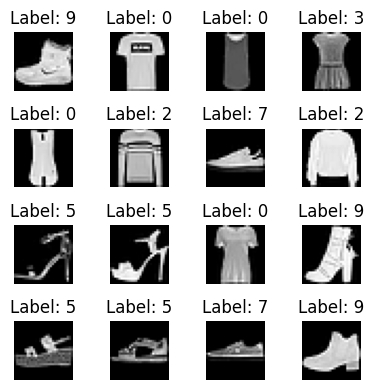

In [ ]:
# prompt: show 16 image from training_data using 4*4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = training_data.__getitem__(i)
    axes[row, col].imshow(im.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3,padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(8*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

In [ ]:
model = CNNNetwork()
model.to(device)
print(model)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=392, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Early Stopping

In [ ]:
def train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_weight = None
    for ep in range(epochs):
        print(f"Epoch {ep+1}\n-------------------------------")
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        val_loss = test_loss(val_loader, model, loss_fn)
        print(f"Epoch {ep+1} Train loss: {train_loss:>7f}  Val loss: {val_loss:>7f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_weight = model.state_dict().copy() #เพราะเป็น Object ถ้าไม่ Copy จะชี้ address ไปเก็บแทน
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break
    print("Done!")
    model.load_state_dict(best_weight)
    return model

def test_loss(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    # size = len(dataloader.dataset) #ไม่ได้ใช้
    num_batches = len(dataloader)
    test_loss=0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    train_loss /= batch
    return train_loss

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=epochs)

Epoch 1
-------------------------------
Epoch 1 Train loss: 2.304219  Val loss: 2.300932
Epoch 2
-------------------------------


KeyboardInterrupt: 

In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted_labels = []
    true_labels = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predicted_labels.extend(pred.argmax(1).cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted_labels, true_labels

# Workshop II 01 early stopping
data: [https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link](https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link)

สร้างโมเดล และทำการฝึกโมเดลเพื่อทำนาย (วินิจฉัย) จากภาพเอกซเรย์ โดยการหยุกฝึกด้วย early stopping ฟร้อมวัดประสิทธิภาพ

## Load data

In [ ]:
!gdown --id 1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH
!unzip '/content/Small_Data_CoV2.zip'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH
From (redirected): https://drive.google.com/uc?id=1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH&confirm=t&uuid=e764918b-f11b-45ba-b1c4-809beb590404
To: /content/Small_Data_CoV2.zip
100% 123M/123M [00:02<00:00, 53.0MB/s]
Archive:  /content/Small_Data_CoV2.zip
replace Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132320.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,transforms
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cuda device
num_workers = 2 cores


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (common for many models)
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values to [-1, 1]
])

# Load training, validation, and testing datasets
train_data = datasets.ImageFolder(root='Small_Data_CoV2_train', transform=transform)
val_data = datasets.ImageFolder(root='Small_Data_CoV2_val', transform=transform)
test_data = datasets.ImageFolder(root='Small_Data_CoV2_test', transform=transform)

# DataLoaders to iterate through the datasets
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if data is loaded correctly (Optional)
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break

# Classes in your dataset
classes = train_data.classes
print(f"Classes: {classes}")

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])
Classes: ['Covid', 'Healthy', 'Others']


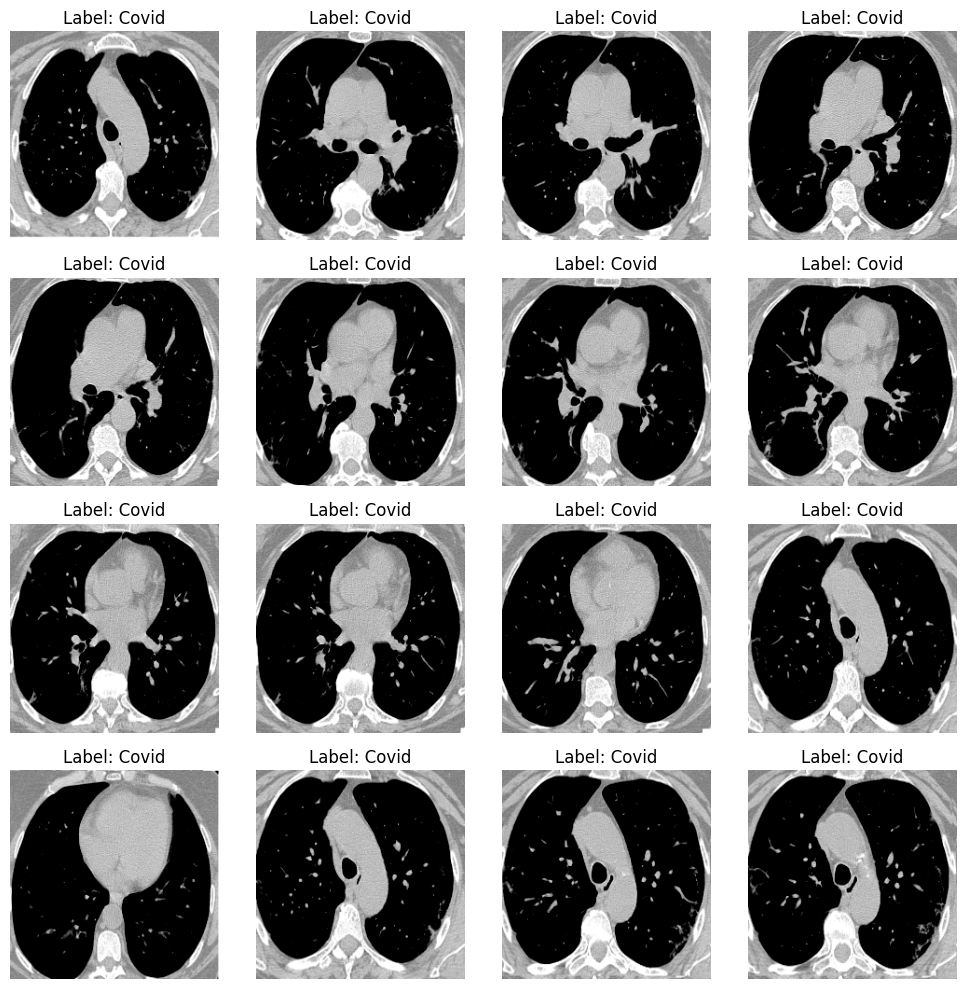

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    row = i // 4
    col = i % 4
    image, label = train_data[i]  # Get the i-th image and label from the dataset
    image = image.permute(1, 2, 0)  # Rearrange dimensions for plotting (CxHxW to HxWxC)
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {classes[label]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
im,label=train_data.__getitem__(0)
print(im.shape)
print(label)

torch.Size([3, 224, 224])
0


## CNN structure

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential( #Input 224
            nn.Conv2d(3, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 16, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 8, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(8*56*56, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Tanh(),
            )


    def forward(self, x):
        x = self.conv(x)
        # print(f"Shape after convolution: {x.shape}")
        x = self.flatten(x)
        out = self.fc_layers(x)
        return out

print(f"Using {device} device")

Using cuda device


In [ ]:
model = CNNModel()
model.to(device)
print(model)

CNNModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=25088, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
    (5): Tanh()
  )
)


## Trainloop with Early Stopping

In [ ]:
def train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_weight = None
    for ep in range(epochs):
        print(f"Epoch {ep+1}\n-------------------------------")
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        val_loss = test_loss(val_loader, model, loss_fn)
        print(f"Epoch {ep+1} Train loss: {train_loss:>7f}  Val loss: {val_loss:>7f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_weight = model.state_dict().copy() #เพราะเป็น Object ถ้าไม่ Copy จะชี้ address ไปเก็บแทน
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break
    print("Done!")
    model.load_state_dict(best_weight)
    return model

def test_loss(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss=0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    train_loss /= batch
    return train_loss

In [ ]:
learning_rate = 1e-3
batch_size = 32
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=epochs)

Epoch 1
-------------------------------
Epoch 1 Train loss: 1.168780  Val loss: 1.104528
Epoch 2
-------------------------------
Epoch 2 Train loss: 1.167470  Val loss: 1.103529
Epoch 3
-------------------------------
Epoch 3 Train loss: 1.165520  Val loss: 1.102517
Epoch 4
-------------------------------
Epoch 4 Train loss: 1.163671  Val loss: 1.101508
Epoch 5
-------------------------------
Epoch 5 Train loss: 1.161514  Val loss: 1.100523
Epoch 6
-------------------------------
Epoch 6 Train loss: 1.159968  Val loss: 1.099514
Epoch 7
-------------------------------
Epoch 7 Train loss: 1.157889  Val loss: 1.098502
Epoch 8
-------------------------------
Epoch 8 Train loss: 1.155945  Val loss: 1.097495
Epoch 9
-------------------------------
Epoch 9 Train loss: 1.154173  Val loss: 1.096441
Epoch 10
-------------------------------
Epoch 10 Train loss: 1.152382  Val loss: 1.095419
Epoch 11
-------------------------------
Epoch 11 Train loss: 1.150188  Val loss: 1.094393
Epoch 12
--------

CNNModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=25088, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
    (5): Tanh()
  )
)

In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted_labels = []
    true_labels = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predicted_labels.extend(pred.argmax(1).cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted_labels, true_labels

In [ ]:
test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 41.5%, Avg loss: 1.082132 



([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
